In [1]:
from burstextractor.burstlist import download_burst_list, process_burst_list
from burstextractor.timeutils import extract_time, fix_typos_in_time, fix_24_hour_time, create_datetime, check_valid_date, adjust_year_month
from burstextractor.data_utils import explode_instruments_long_clean_instruments, keep_only_type_I_to_VI
from spectogram_utils import spec_to_pd_dataframe, plot_spectogram, download_spectogram_from_df_row
import pandas as pd
import numpy as np
import datetime
import matplotlib.pyplot as plt 
from radiospectra.sources import CallistoSpectrogram

In [2]:
burst_list = pd.read_excel('burst_list.xlsx')
burst_list.sample(5)

,date,time,type,instruments,time_start,time_end,date_start,date_end,datetime_start,datetime_end
16972,20220919,17:21-17:22,III,Arecibo-Observatory,17:21,17:22,20220919,20220919,2022-09-19 17:21:00,2022-09-19 17:22:00
14373,20220714,01:42-01:43,III,ALASKA-HAARP,01:42,01:43,20220714,20220714,2022-07-14 01:42:00,2022-07-14 01:43:00
2795,20210831,05:36-05:37,III,Australia-ASSA,05:36,05:37,20210831,20210831,2021-08-31 05:36:00,2021-08-31 05:37:00
5369,20220109,14:07-14:07,III,HUMAIN,14:07,14:07,20220109,20220109,2022-01-09 14:07:00,2022-01-09 14:07:00
1733,20210625,03:58-03:59,III,Australia-ASSA,03:58,03:59,20210625,20210625,2021-06-25 03:58:00,2021-06-25 03:59:00


In [3]:
IMAGE_FOLDER = 'images'
IMAGE_LEN = pd.Timedelta('2h')
# CallistoSpectrogram.from_range('ALASKA-ANCHORAGE', '2023-01-01T20:00:00', '2023-01-02T04:50:00')

In [4]:
spec = download_spectogram_from_df_row(burst_list.iloc[1782], IMAGE_LEN)

dict_values([[<radiospectra.sources.callisto.CallistoSpectrogram object at 0x7f046ea6d490>, <radiospectra.sources.callisto.CallistoSpectrogram object at 0x7f046e6d5210>, <radiospectra.sources.callisto.CallistoSpectrogram object at 0x7f046d49f9d0>, <radiospectra.sources.callisto.CallistoSpectrogram object at 0x7f046d5ee150>, <radiospectra.sources.callisto.CallistoSpectrogram object at 0x7f046e66f1d0>, <radiospectra.sources.callisto.CallistoSpectrogram object at 0x7f046d488e90>, <radiospectra.sources.callisto.CallistoSpectrogram object at 0x7f046d4bc150>, <radiospectra.sources.callisto.CallistoSpectrogram object at 0x7f046d4c4610>, <radiospectra.sources.callisto.CallistoSpectrogram object at 0x7f046d4d3450>], [<radiospectra.sources.callisto.CallistoSpectrogram object at 0x7f046d638f90>, <radiospectra.sources.callisto.CallistoSpectrogram object at 0x7f046d4a4990>, <radiospectra.sources.callisto.CallistoSpectrogram object at 0x7f046e66c610>, <radiospectra.sources.callisto.CallistoSpectrogr

/home/vincenzo/mambaforge-pypy3/envs/sunflare_prediction/lib/python3.11/site-packages/numpy/lib/nanfunctions.py:1872: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,


15 channels eliminated
Eliminating sharp jumps between channels ...
370 channels eliminated


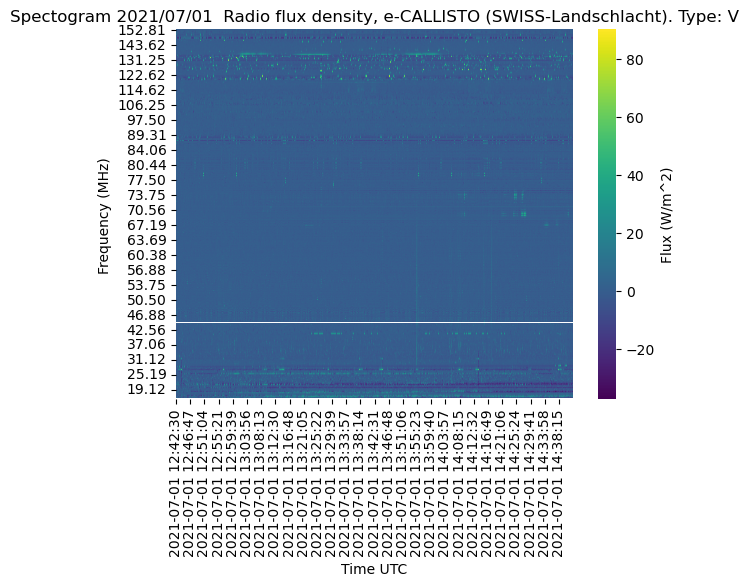

In [5]:
plot_spectogram(spec)

In [6]:
desc = spec.T.describe().T[['mean', 'std', 'min', 'max']]
desc = desc.resample('1min').agg(['mean', 'std', 'min', 'max'])
# Add label
desc['type'] = np.where((desc.index >= burst_list.iloc[1782].datetime_start) & (desc.index <= burst_list.iloc[12505].datetime_end), 1, 0)

In [7]:
train = desc.sample(frac=0.8, random_state=0)
test = desc.drop(train.index)

In [8]:
from xgboost import XGBClassifier
model = XGBClassifier()
model.fit(train.drop('type', axis=1), train['type'])

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=100, n_jobs=None, num_parallel_tree=None,
              predictor=None, random_state=None, ...)

In [9]:
from sklearn.metrics import classification_report
print(classification_report(test['type'], model.predict(test.drop('type', axis=1))))

              precision    recall  f1-score   support

           0       0.67      0.89      0.76         9
           1       0.92      0.73      0.81        15

    accuracy                           0.79        24
   macro avg       0.79      0.81      0.79        24
weighted avg       0.82      0.79      0.79        24



In [10]:
from sklearn.metrics import classification_report
print(classification_report(train['type'], model.predict(train.drop('type', axis=1))))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00        51
           1       1.00      1.00      1.00        46

    accuracy                           1.00        97
   macro avg       1.00      1.00      1.00        97
weighted avg       1.00      1.00      1.00        97



<AxesSubplot: title={'center': 'Feature importance'}, xlabel='F score', ylabel='Features'>

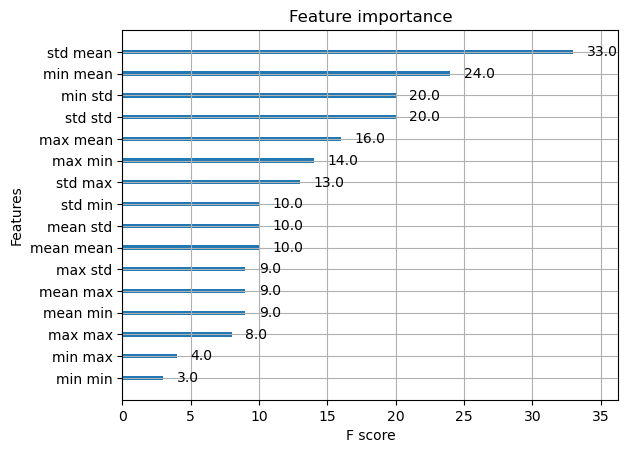

In [11]:
from xgboost import plot_importance
plot_importance(model)